In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset test

In [ ]:
from PrimeCNNv3.imports import *
from PrimeCNNv3.utils.data.dataset import *

In [ ]:
#hide



SEED = 0

np.random.seed(SEED)
random.seed(SEED)

train_filepath = Path('../../../CovidX/data/train_COVIDx5.txt')

with open(train_filepath,'r') as file:
    cxr_list = np.array([line.rstrip('\n') for line in file])



In [ ]:
train_data = get_dataset(train_filepath, seed=0)

In [ ]:
#hide
train_lst, valid_lst = get_train_val_split(train_data, valid_pct=0.2, seed = 0)

In [ ]:
#hide
#stats

train_count = {'normal': 0, 'pneumonia': 0, 'COVID-19': 0}
valid_count = {'normal': 0, 'pneumonia': 0, 'COVID-19': 0}

#for train ds
for element in train_lst:
    pathlogy = element.split()[-2]
    train_count[pathlogy] += 1

#for valid ds
for element in valid_lst:
    pathlogy = element.split()[-2]
    valid_count[pathlogy] += 1

In [ ]:
#hide
print(train_count)
print(valid_count)

{'normal': 6427, 'pneumonia': 4332, 'COVID-19': 408}
{'normal': 1539, 'pneumonia': 1143, 'COVID-19': 109}


In [ ]:
train_ds = CovidXDataset(Path('../../../CovidX/data/train'), train_lst, seed = 0, transform = A.Compose([A.Resize(224,224)]))
valid_ds = CovidXDataset(Path('../../../CovidX/data/train'), valid_lst, seed = 0)

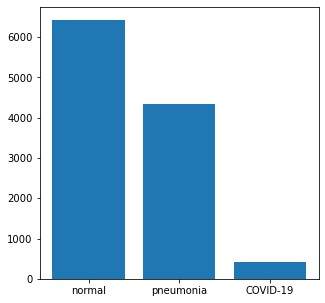

In [ ]:
train_ds.show_distribution()

# Using WeightedRandomSampler for ROS aand RUS

In [ ]:
train_dl = DataLoader(train_ds, batch_size = 64, sampler = train_ds.get_Weighted_RandomSampler())

In [ ]:
class_distrib = {0:0, 1:0, 2:0}
for xb, yb in train_dl:
    class_distrib[0] += len(yb[yb == 0])
    class_distrib[1] += len(yb[yb == 1])
    class_distrib[2] += len(yb[yb == 2])  

<BarContainer object of 3 artists>

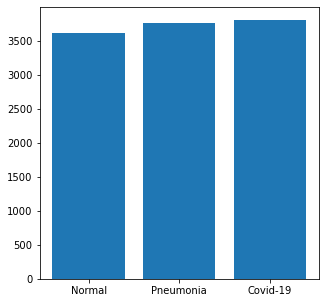

In [ ]:
_, ax = plt.subplots(1,1, figsize = (5,5))
ax.bar(['Normal','Pneumonia', 'Covid-19'], class_distrib.values())

numDataPoints = 1000
data_dim = 5
bs = 100

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),
                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))

print( 'target train 0/1: {}/{}'.format(
    len(np.where(target == 0)[0]), len(np.where(target == 1)[0])))

class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

weight

#samples_weight = torch.from_numpy(samples_weight)
#samples_weigth = samples_weight.double()
#sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

#target = torch.from_numpy(target).long()
#train_dataset = torch.utils.data.TensorDataset(data, target)

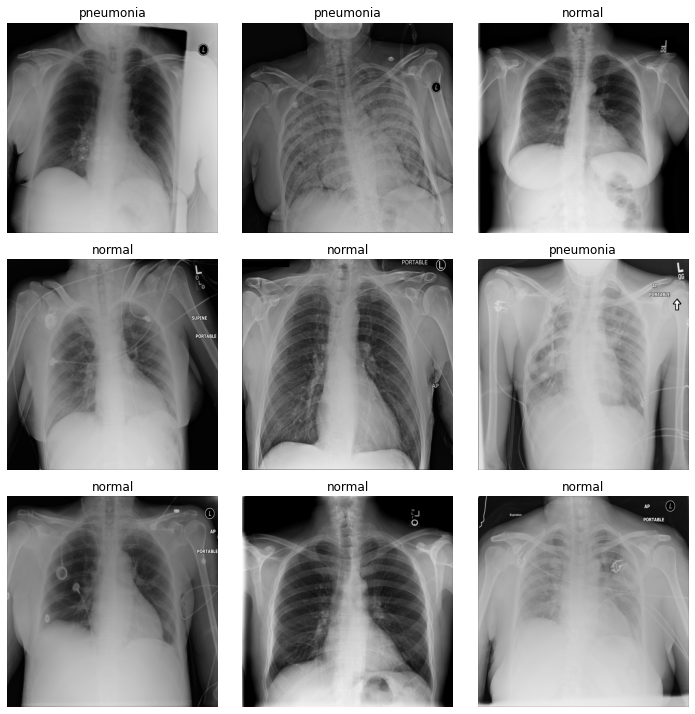

In [ ]:
train_ds.show_images(10, nrows=3, rand=False)

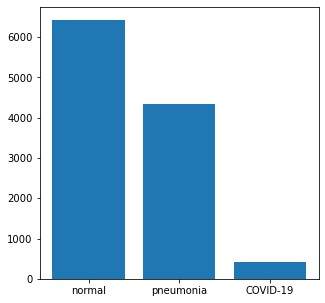

In [ ]:
train_ds.show_distribution()

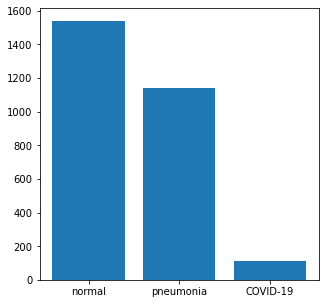

In [ ]:
valid_ds.show_distribution()

# Learner test

In [ ]:
#hide
import os
from torchvision import datasets, models, transforms
from PrimeCNNv3.utils.data.dataloaders import DataLoaders
from PrimeCNNv3.utils.data.dataset import Dataset
from PrimeCNNv3.callbacks import *
from PrimeCNNv3.metric import *
from PrimeCNNv3.learner import *

In [ ]:
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`"
    def __init__(self, size=None):
        super(AdaptiveConcatPool2d,self).__init__()
        self.size = size or 1
        self.ap = nn.AdaptiveAvgPool2d(self.size)
        self.mp = nn.AdaptiveMaxPool2d(self.size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [ ]:
random_seed(0)
head = nn.Sequential(
                     nn.Flatten(),
                     nn.BatchNorm1d(num_features=1024,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                     nn.Dropout(p = 0.25, inplace = False),
                     nn.Linear(in_features=1024, out_features=512, bias= False),
                     nn.ReLU(inplace=True),
                     nn.BatchNorm1d(num_features=512,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                     nn.Dropout(p = 0.5, inplace = False),
                     nn.Linear(in_features=512, out_features=10, bias= False)
                     
)

In [ ]:
#hide
random_seed(0)
model = models.resnet18(pretrained = True)
model.avgpool = nn.Sequential(AdaptiveConcatPool2d())
model.fc = head
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
dataset1 = datasets.CIFAR10('../data', train=True, download=True,
                       transform=transform)
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1,batch_size = 256, pin_memory = True)
                                       
valid_loader = torch.utils.data.DataLoader(testset, batch_size = 4, pin_memory = True)
dls = DataLoaders(train_loader, valid_loader, device='cuda') 

cbs = [SetupLearnerCB(),Recorder(),ShowStats()]

learn = Learner(model,dls, metric = [accuracy, precision, recall, f1score], 
                cbs = cbs,loss_func=nn.CrossEntropyLoss(), 
                opt_func=torch.optim.AdamW )

Files already downloaded and verified
Files already downloaded and verified


Layer :0 Freeze
Layer :1 Freeze
Layer :2 Freeze
Layer :3 Freeze
Layer :4 Freeze
Layer :5 Freeze
Layer :6 Freeze
Layer :7 Freeze
Layer :8 unFreeze
Layer :9 unFreeze


Loss exploding.. stopping training
Suggested LR : 
min_lr: 0.0035111919045448304 
lr_steep: 0.0008111308561637998


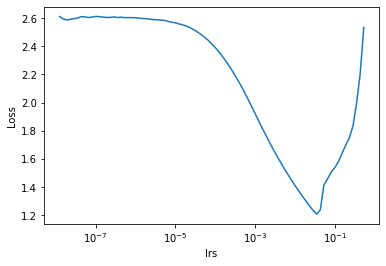

In [ ]:
#hide
random_seed(0)
learn.freeze_to(-2)
learn.lr_finder(wd=1e-04)

Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,0.877314,0.711254,0.7609,0.761791,0.7609,0.760543,00:49
1,0.67385,0.802838,0.7408,0.760605,0.7408,0.735384,00:53
2,0.642058,1.100561,0.6616,0.721899,0.6616,0.648299,00:57
3,0.617181,1.072709,0.6966,0.720048,0.6966,0.691266,01:03
4,0.542506,0.888746,0.7323,0.768099,0.7323,0.730461,00:59
5,0.447686,0.871089,0.7454,0.771107,0.7454,0.737393,01:02
6,0.347428,0.77416,0.7703,0.775676,0.7703,0.770463,01:04
7,0.282886,0.830281,0.7831,0.785842,0.7831,0.781189,01:05
8,0.215753,0.859575,0.7815,0.792377,0.7815,0.783354,01:06
9,0.154255,0.896204,0.7855,0.788559,0.7855,0.786317,01:02


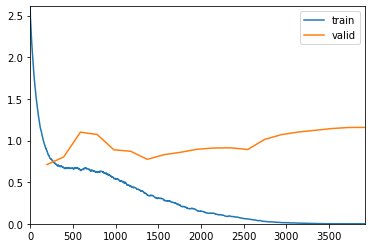

In [ ]:
random_seed(0)
learn.one_cycle_fit(20,max_lr=0.0035,wd = 1e-04)

Layer :0 unFreeze
Layer :1 unFreeze
Layer :2 unFreeze
Layer :3 unFreeze
Layer :4 unFreeze
Layer :5 unFreeze
Layer :6 unFreeze
Layer :7 unFreeze
Layer :8 unFreeze
Layer :9 unFreeze


Loss exploding.. stopping training
Suggested LR : 
min_lr: 0.008111308515071868 
lr_steep: 0.00018738173821475357


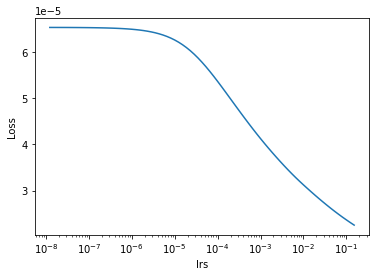

In [ ]:
learn.unfreeze()
learn.lr_finder(wd=1e-04)

Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,0.007831,1.39441,0.8079,0.807993,0.8079,0.807186,01:01
1,0.065575,1.046524,0.7798,0.788433,0.7798,0.78035,01:02
2,0.22681,0.871028,0.7698,0.773353,0.7698,0.768974,01:03
3,0.373092,1.050503,0.7031,0.749947,0.7031,0.704406,01:03
4,0.417149,0.883773,0.7438,0.759291,0.7438,0.741341,01:04
5,0.400253,0.94643,0.7259,0.771133,0.7259,0.733293,01:04
6,0.385464,0.877956,0.7431,0.763427,0.7431,0.746495,01:05
7,0.350303,0.900077,0.7423,0.755837,0.7423,0.745704,01:05
8,0.311297,0.866968,0.7484,0.753708,0.7484,0.749679,01:03
9,0.267471,0.971184,0.7462,0.758815,0.7462,0.745212,00:58


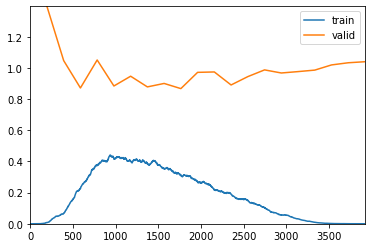

In [ ]:
random_seed(0)
learn.one_cycle_fit(20,max_lr=0.0081,wd = 1e-01)

Loss exploding.. stopping training
Suggested LR : 
min_lr: 0.0015199110843241216 
lr_steep: 0.00023101296392269433


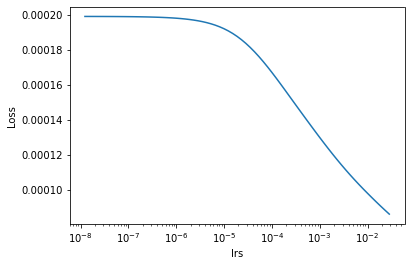

In [ ]:
learn.lr_finder(wd=1e-01)

In [ ]:
preds, target = learn.cbs[1].accumetric.get_target_preds_np()

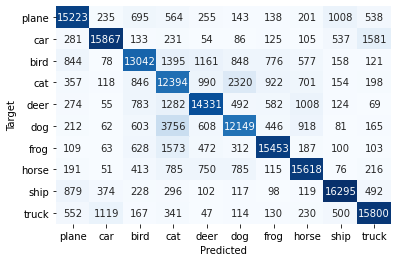

In [ ]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(preds = preds, target=target, labels=classes)

In [ ]:
learn.save_model(Path('model.pth'))

In [ ]:
learn.load_model(Path('model.pth'))